In [1]:
from PIL import Image
import torch
from torchvision.models import vgg19, VGG19_Weights
import torchvision.transforms as transforms

from functools import partial
from tqdm import tqdm
from torchvision.transforms.functional import normalize
from torch.nn.functional import mse_loss

In [2]:
print(f'Using PyTorch version {torch.__version__}')
print(f'Using CUDA version {torch.version.cuda}')
print(f'Using cuDNN version {torch.backends.cudnn.version()}')

Using PyTorch version 2.2.1+cu121
Using CUDA version 12.1
Using cuDNN version 8902


## Default Parameters

In [3]:
NN_MODEL_MEAN = [0.485, 0.456, 0.406]
NN_MODEL_STD = [0.229, 0.224, 0.225]
N_ITER = 1000
IM_SIZE = (256, 256)

## Device

In [4]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

## Loss Function

In [5]:
def gram(tnsr: torch.Tensor) -> torch.Tensor:
    """Computes Gram matrix for the input batch tensor.

    Args:
        tnsr (torch.Tensor): input tensor of the Size([B, C, H, W]).

    Returns:
        G (torch.Tensor): output tensor of the Size([B, C, C]).
    """
    B, C, H, W = tnsr.shape
    F = tnsr.view(B, C, H * W)
    G = torch.einsum("bik,bjk->bij", F, F)
    return G


def loss_func(input: torch.Tensor, target: torch.Tensor, weight: float = 1.0):
    """Computes MSE Loss for 2 Gram matrices of the same type.

    Args:
        input (torch.Tensor):
        target (torch.Tensor):
        weight (float):

    Returns
        loss (torch.Tensor): computed loss value.
    """
    assert input.size() == target.size(), "Input and target must have the same size"

    B, N, _, _ = input.size()
    M = input.size(-2) * input.size(-1)

    Gi, Gt = gram(input), gram(target)

    loss = weight * (1 / (4 * N**2 * M**2)) * mse_loss(Gi, Gt, reduction="sum") / B

    return loss

## Layer mapping

Create a mapping between the original layer names and the names in the PyTorch model.  
Also define layer weights, as per the original implementation

In [6]:
# %% Define the layers to include in the texture model and weights
tex_layers = ["pool4", "pool3", "pool2", "pool1", "conv1_1"]
tex_weights = [1e9, 1e9, 1e9, 1e9, 1e9]
layer_weight_dict = {
    layer: weight for layer, weight in zip(tex_layers, tex_weights)
}

vgg19_layers = {
    "pool4": "27",  # The fourth pooling layer
    "pool3": "18",  # The third pooling layer
    "pool2": "9",  # The second pooling layer
    "pool1": "4",  # The first pooling layer
    "conv1_1": "0",  # The first conv layer
}

## Model

In [7]:
# Initialize the model
model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

# Set the model to evaluation mode
model.eval()

# Move your model to `device`
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Load image and transform

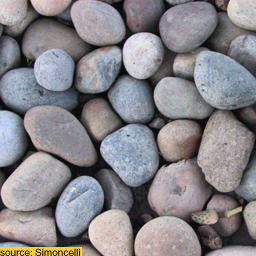

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize(IM_SIZE, Image.LANCZOS),  # Resize to the desired size
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(
            mean=NN_MODEL_MEAN, std=NN_MODEL_STD  # Normalize using mean, std of model
        ),
    ]
)

# Load the image
source_img = Image.open("pebbles.jpg")

source_img

In [9]:
# Apply the transformations
source_img = transform(source_img)

# Add an extra dimension for the batch size
source_img = source_img.unsqueeze(0)

# Send to device
source_img = source_img.to(device)

## Forward Sweep

Pass the image through the network and save the layer-responses.

In [10]:
target_parameters = {}
hook_handles = []

# Define a hook function that will save the output of each layer
def hook(module, input, output, key):
    target_parameters[key] = output.detach()

# Register the hook for each layer in tex_layers
for layer in tex_layers:
    vgg19_layer = vgg19_layers[layer]
    handle = model.features[int(vgg19_layer)].register_forward_hook(partial(hook, key=layer))
    hook_handles.append(handle)

# Pass the image through the model
with torch.no_grad():
    _ = model(source_img)

# Remove the hooks
for handle in hook_handles:
    handle.remove()

del hook_handles, handle

## Texture Synthesis

In [11]:
synthesis = torch.rand_like(source_img)
synthesis = normalize(synthesis, NN_MODEL_MEAN, NN_MODEL_STD)
synthesis.requires_grad_(True)

optimizer = torch.optim.LBFGS(
    [synthesis],
    tolerance_grad=0.0,
    tolerance_change=0.0,
    line_search_fn="strong_wolfe",
)

# Forward Hook
synth_values = {}


def hook(module, input, output, key):
    synth_values[key] = output


# Register the hook for each layer in tex_layers
for layer in tex_layers:
    vgg19_layer = vgg19_layers[layer]
    handle = model.features[int(vgg19_layer)].register_forward_hook(
        partial(hook, key=layer)
    )


def closure():
    optimizer.zero_grad()

    # compute output
    _ = model(synthesis)

    total_loss = 0
    for layer in target_parameters.keys():

        # compute loss
        loss = loss_func(
            synth_values[layer], target_parameters[layer], layer_weight_dict[layer]
        )

        total_loss += loss  # total loss is the sum of all layer loss

    total_loss.backward()

    return total_loss

In [12]:
# Run the optimizer
for i in tqdm(range(N_ITER), desc="Texture Synthesis - Optimizing"):
    optimizer.step(closure)

Texture Synthesis - Optimizing: 100%|█████████████████████████████████| 1000/1000 [02:26<00:00,  6.84it/s]


## Tensor to image

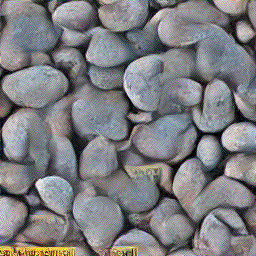

In [13]:
synth = synthesis.detach().cpu()  # Detach from the computation graph and move to CPU
synth = synth.squeeze(0)  # Remove the batch dimension

# Reverse the normalization
std_tensor = torch.Tensor(NN_MODEL_STD).view(-1, 1, 1).to(synth.device)
mean_tensor = torch.Tensor(NN_MODEL_MEAN).view(-1, 1, 1).to(synth.device)

synth *= std_tensor
synth += mean_tensor

# Clip the values to be between 0 and 1
synth.clamp_(0, 1)

# Convert to a PIL Image and save
synth_img = transforms.ToPILImage()(synth)
synth_img.save("pebbles_synth.jpg")
synth_img